# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Требуется модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75. Проверку *accuracy* на тестовой выборке нужно провести самостоятельно.

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
<ul>
    <li><em>сalls</em> — количество звонков,</li>
    <li><em>minutes</em> — суммарная длительность звонков в минутах,</li>
    <li><em>messages</em> — количество sms-сообщений,</li>
    <li><em>mb_used</em> — израсходованный интернет-трафик в Мб,</li>
    <li><em>is_ultra</em> — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).</li>
</ul>

## Откройте и изучите файл

In [1]:
from pylab import rcParams
rcParams['figure.figsize'] = (9,6)

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',50)

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

import numpy as np


import seaborn as sns
sns.set_style("whitegrid", {'figure.facecolor': '0.97',});
sns.set_palette("Set2");

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings


<Figure size 648x432 with 0 Axes>

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv', sep=',')
except:
    df = pd.read_csv('datasets\yandex_06_users_behavior.csv', sep=',')


In [3]:
#сделаем треугольную матрицу heatmap без диагональных элементов
def corr_triag_heatmap(corr, title_str):
    #mask = np.zeros_like(corr)
    #mask[np.triu_indices_from(mask)] = True
    mask=np.triu(np.full(corr.shape, True))
    corr=corr.iloc[1:,:-1]
    mask=pd.DataFrame(mask).iloc[1:,:-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize = (corr.shape[0]*1.2,(corr.shape[0]*0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_zero_plots = False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    if show_corr_zero_plots:
        # готовим матрицу корреляций нулей
        t = df.isin([0,'0']).sum().sort_values()
        indx = t[t>0].index
        if len(indx)>0:
            print()
            corr=df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isin([0,'0']).sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs()+0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

    # статистики
    display(df.describe(include='all').transpose())
    
    pd.plotting.scatter_matrix(df, figsize=(16,10));


------SAMPLE--------


,calls,minutes,messages,mb_used,is_ultra
1337,94.000,609.820,63.000,"20,178.280",0
2362,72.000,489.990,83.000,"13,889.730",0
2713,70.000,465.080,38.000,"19,819.400",0
1348,69.000,528.670,47.000,"22,323.980",0
404,30.000,169.020,13.000,"16,626.530",0



------DTYPES--------
calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object


------NaN & zero--------
         NA  filled  zero %na
calls     -    3214    40   -
minutes   -    3214    40   -
messages  -    3214   497   -
mb_used   -    3214    11   -
is_ultra  -    3214  2229   -



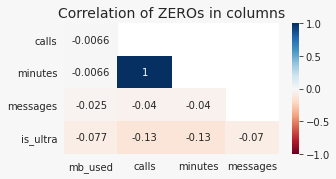

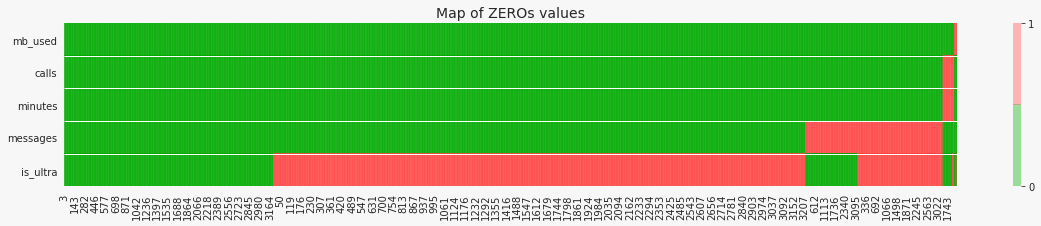

,count,mean,std,min,25%,50%,75%,max
calls,"3,214.000",63.039,33.236,0.000,40.000,62.000,82.000,244.000
minutes,"3,214.000",438.209,234.570,0.000,274.575,430.600,571.927,"1,632.060"
messages,"3,214.000",38.281,36.148,0.000,9.000,30.000,57.000,224.000
mb_used,"3,214.000","17,207.674","7,570.968",0.000,"12,491.903","16,943.235","21,424.700","49,745.730"
is_ultra,"3,214.000",0.306,0.461,0.000,0.000,0.000,1.000,1.000


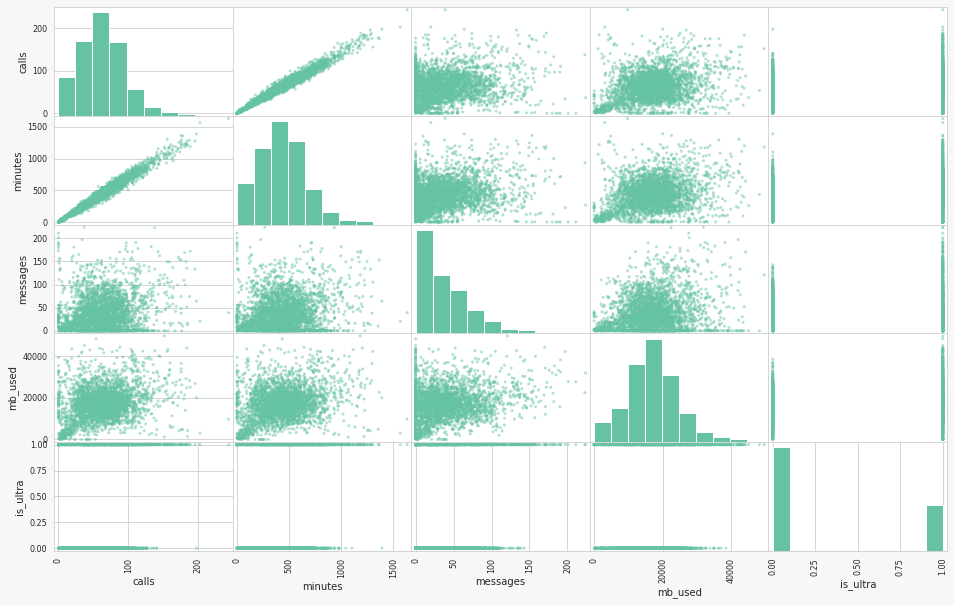

In [4]:
evaluate_df(df, True)

Тарифы на связь зависят от двух ключевых параметров: число минут и число гигабайт

Познакомимся чем отличается ULTRA и не ULTRA

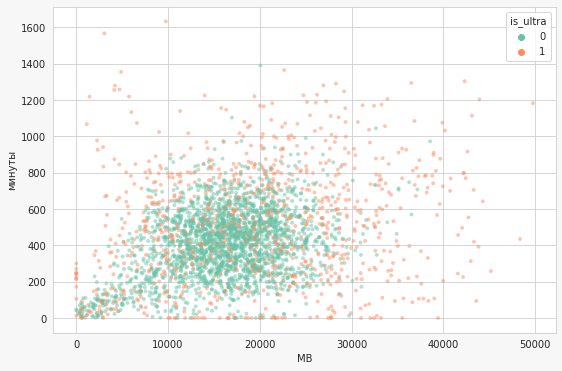

In [5]:
g= sns.scatterplot( x='mb_used', y='minutes', data=df, hue='is_ultra'
                , alpha=0.5
                , edgecolor = 'none'
                , s=15
);
g.set_xlabel('MB')
g.set_ylabel('минуты')
plt.show()

<Figure size 1152x720 with 0 Axes>

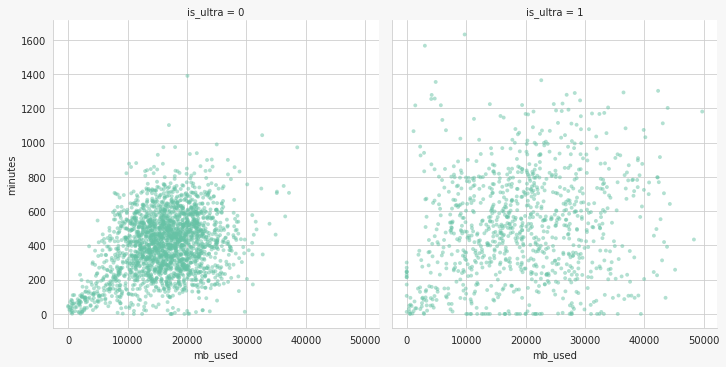

In [6]:
plt.figure(figsize = (16,10))
sns.relplot(x='mb_used', y='minutes', data=df, col='is_ultra'
            , alpha=0.5
            , edgecolor = 'none'
            , s=15
            );


### Вывод

1. Даные без пропусков, чистые, без явных выбросов
2. Число объектов в датасете 3214, этого должно быть достаточно для обучения моделей, причем можно будет поподбирать гиперпараметры активно.
3. число точек is_ultra==1 составляет 0.306 от всей выборки. Это приемлемо. Главное, что не совсем мало. Модель должна суметь научиться
4. calls и minutes имеют высокую корреляцию
5. Разница между ultra и not_ultra в разбросе точек, причем у ultra во все стороны. Облака точек пересекаются и центры близки, значит почти любая модель будет регулярно совершать ошибки около центра ultra=0. Вопрос в том, какая модель сможет уловить разницу лучше вне облака ultra=0

calls и minutes имеют высокую корреляцию. Нужно выбрать и оставить только один признак из них. В тарифах обычно не ограничивают число звонков, но ограничивают число минут, поэтому оставим 'minutes' и удалим признак 'calls'

In [7]:
df = df.drop('calls', axis=1)

## Разбейте данные на выборки

За целевой признак берем столбец is_ultra

Делим данные на три части: тренировочную. валидационную и тестовую в пропорциях 3:1:1

In [8]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

features_tv, features_test, target_tv, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(features_tv, target_tv, test_size=0.25, random_state=12345)

Проверим число объектов в выборках

In [9]:
print('Обучающая выборка:',features_train.shape[0])
print('Валидационная выборка:',features_valid.shape[0])
print('Тестовая выборка:',features_test.shape[0])

Обучающая выборка: 1928
Валидационная выборка: 643
Тестовая выборка: 643


### Вывод
Данные разделены корректно

## Исследуйте модели

In [10]:
# Функция строит heatmap для массива значений точности
# испольлзуется для просмотра результатов подбора гиперпараметров модели
def show_heatmap_accuracy(arr_iter, q=0.5):
    res_df = pd.DataFrame(arr_iter, columns=['ind', 'col', 'accuracy'])
    t = res_df.pivot_table(index='ind', columns='col', values='accuracy')
    vm = res_df['accuracy'].quantile(q)
    plt.figure(figsize = (16,len(t)**0.5 *3))
    sns.heatmap(t, annot=True, cmap='Greens', fmt='.4f', vmin=vm);
    plt.show()

### Строим модель DecisionTreeClassifier

В циклах перебираем гиперпараметры criterion, min_samples_leaf, min_samples_split, max_depth.</br>
каждую модель оцениваем на валидационной выборке и результаты (параметры модели и accuracy) записываем в массив. 

После цикла перебора гиперпараметров модели построим heatmap, на ктором будет видно наглядно при какой глубине и каких параметрах точность наилучшая

Acuracy наилучшей модели DecisionTreeClassifier на валидационной выборке: 0.7931570762052877 
параметры: DecisionTreeClassifier, depth=8, criterion=entropy_minsample=10_minleaf=5


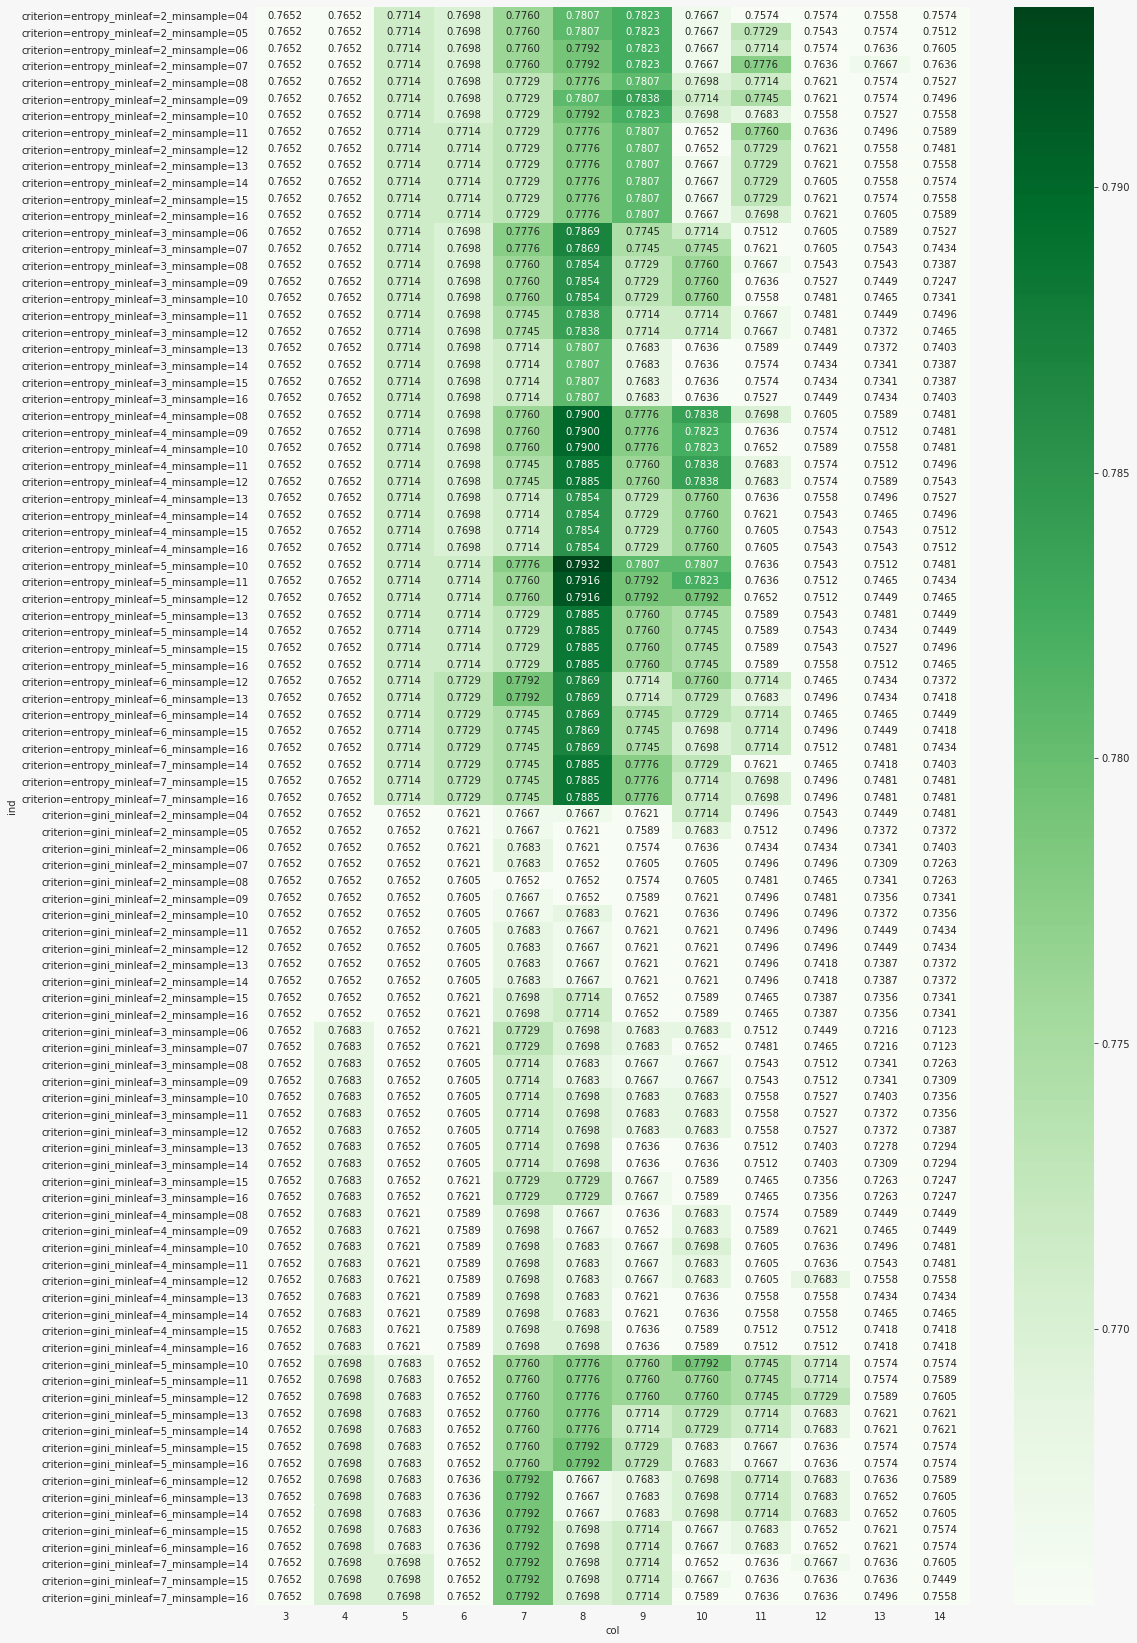

CPU times: user 32 s, sys: 2.77 s, total: 34.8 s
Wall time: 35.3 s


In [11]:
%%time

best_tree_model = None
best_result = 0

criterion_lst = ["gini", "entropy"]
arr_iter = []
for criterion in criterion_lst:
    for mslf in range(2,8):
        for mssp in range(mslf*2,17,1):
            for depth in range(3,15,1):
                model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion=criterion
                                               , min_samples_split=mssp, min_samples_leaf=mslf)

                model.fit(features_train, target_train) # обучим модель


                predictions = model.predict(features_valid) # получим предсказания модели
                result = accuracy_score(target_valid, predictions) # посчитаем качество модели
                param_str = "DecisionTreeClassifier, depth="+ str(depth) + ', criterion='+criterion+"_minsample="+str(mssp)+"_minleaf="+str(mslf)
                arr_iter.append(
                    [
                        'criterion='+criterion+"_minleaf="+str(mslf)+"_minsample="+str(mssp).zfill(2)
                        , depth
                        , result
                    ]
                )
                if result > best_result:
                    best_tree_model = model
                    best_result = result
                    best_param = param_str
print("Acuracy наилучшей модели DecisionTreeClassifier на валидационной выборке:", best_result
      , "\nпараметры:", best_param)

show_heatmap_accuracy(arr_iter)

### Строим модель LogisticRegression

В циклах перебираем гиперпараметры C (Inverse of regularization strength), solver(Algorithm to use in the optimization problem), max_iter (Maximum number of iterations taken for the solvers to converge).</br>
каждую модель оцениваем на валидационной выборке и результаты (параметры модели и accuracy) записываем в массив. 

Некоторые модели не успели сойтись и выдавали warning, поэтому пришлось подавить сообщения warning при настройке (fit) модели

После цикла перебора гиперпараметров модели построим heatmap, на ктором будет видно наглядно при каком числе итераций и каких параметрах точность наилучшая

Acuracy наилучшей модели LogisticRegression на валидационной выборке: 0.7293934681181959 
параметры: LogReg, solver=newton-cg, max_iter=30_c=1.1


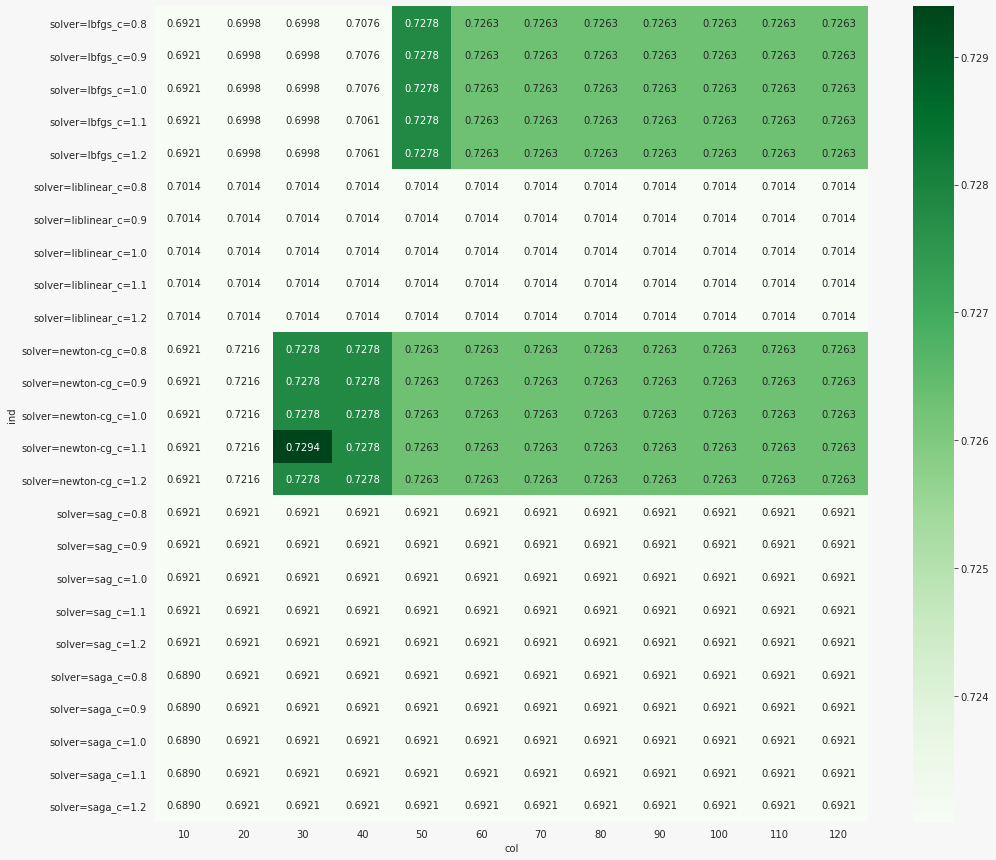

CPU times: user 17.6 s, sys: 519 ms, total: 18.1 s
Wall time: 18.6 s


In [12]:
%%time

best_logreg_model = None
best_result = 0

solvers_lst = ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
arr_iter = []
for s in solvers_lst:
    for c in np.arange(0.8,1.3,0.1):
        for n_iter in range(10,121,10):
            model = LogisticRegression(random_state=12345, solver=s, max_iter=n_iter, C=c)

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model.fit(features_train, target_train) # обучим модель


            predictions = model.predict(features_valid) # получим предсказания модели
            result = accuracy_score(target_valid, predictions) # посчитаем качество модели
            param_str = "LogReg, solver=" + s + ', max_iter=' + str(n_iter) +'_c={:.1f}'.format(c) 
            #print(param_str)
            arr_iter.append([
                'solver='+s+'_c={:.1f}'.format(c)
                , n_iter, result
            ])
            if result > best_result:
                best_logreg_model = model
                best_result = result
                best_param = param_str
print("Acuracy наилучшей модели LogisticRegression на валидационной выборке:", best_result, "\nпараметры:", best_param)

show_heatmap_accuracy(arr_iter, 0.7)

### Строим модель RandomForestClassifier

В циклах перебираем гиперпараметры criterion, min_samples_leaf, min_samples_split, n_estimators, max_depth.</br>
Каждую модель оцениваем на валидационной выборке и результаты (параметры модели и accuracy) записываем в массив. 

После цикла перебора гиперпараметров модели построим heatmap, на ктором будет видно наглядно при каком числе итераций и каких параметрах точность наилучшая

Acuracy наилучшей модели RandomForestClassifier на валидационной выборке: 0.8087091757387247 
параметры: RandomForestClassifier: n_estimators =18, max_depth=11, criterion=gini_minsample=5_minleaf=2


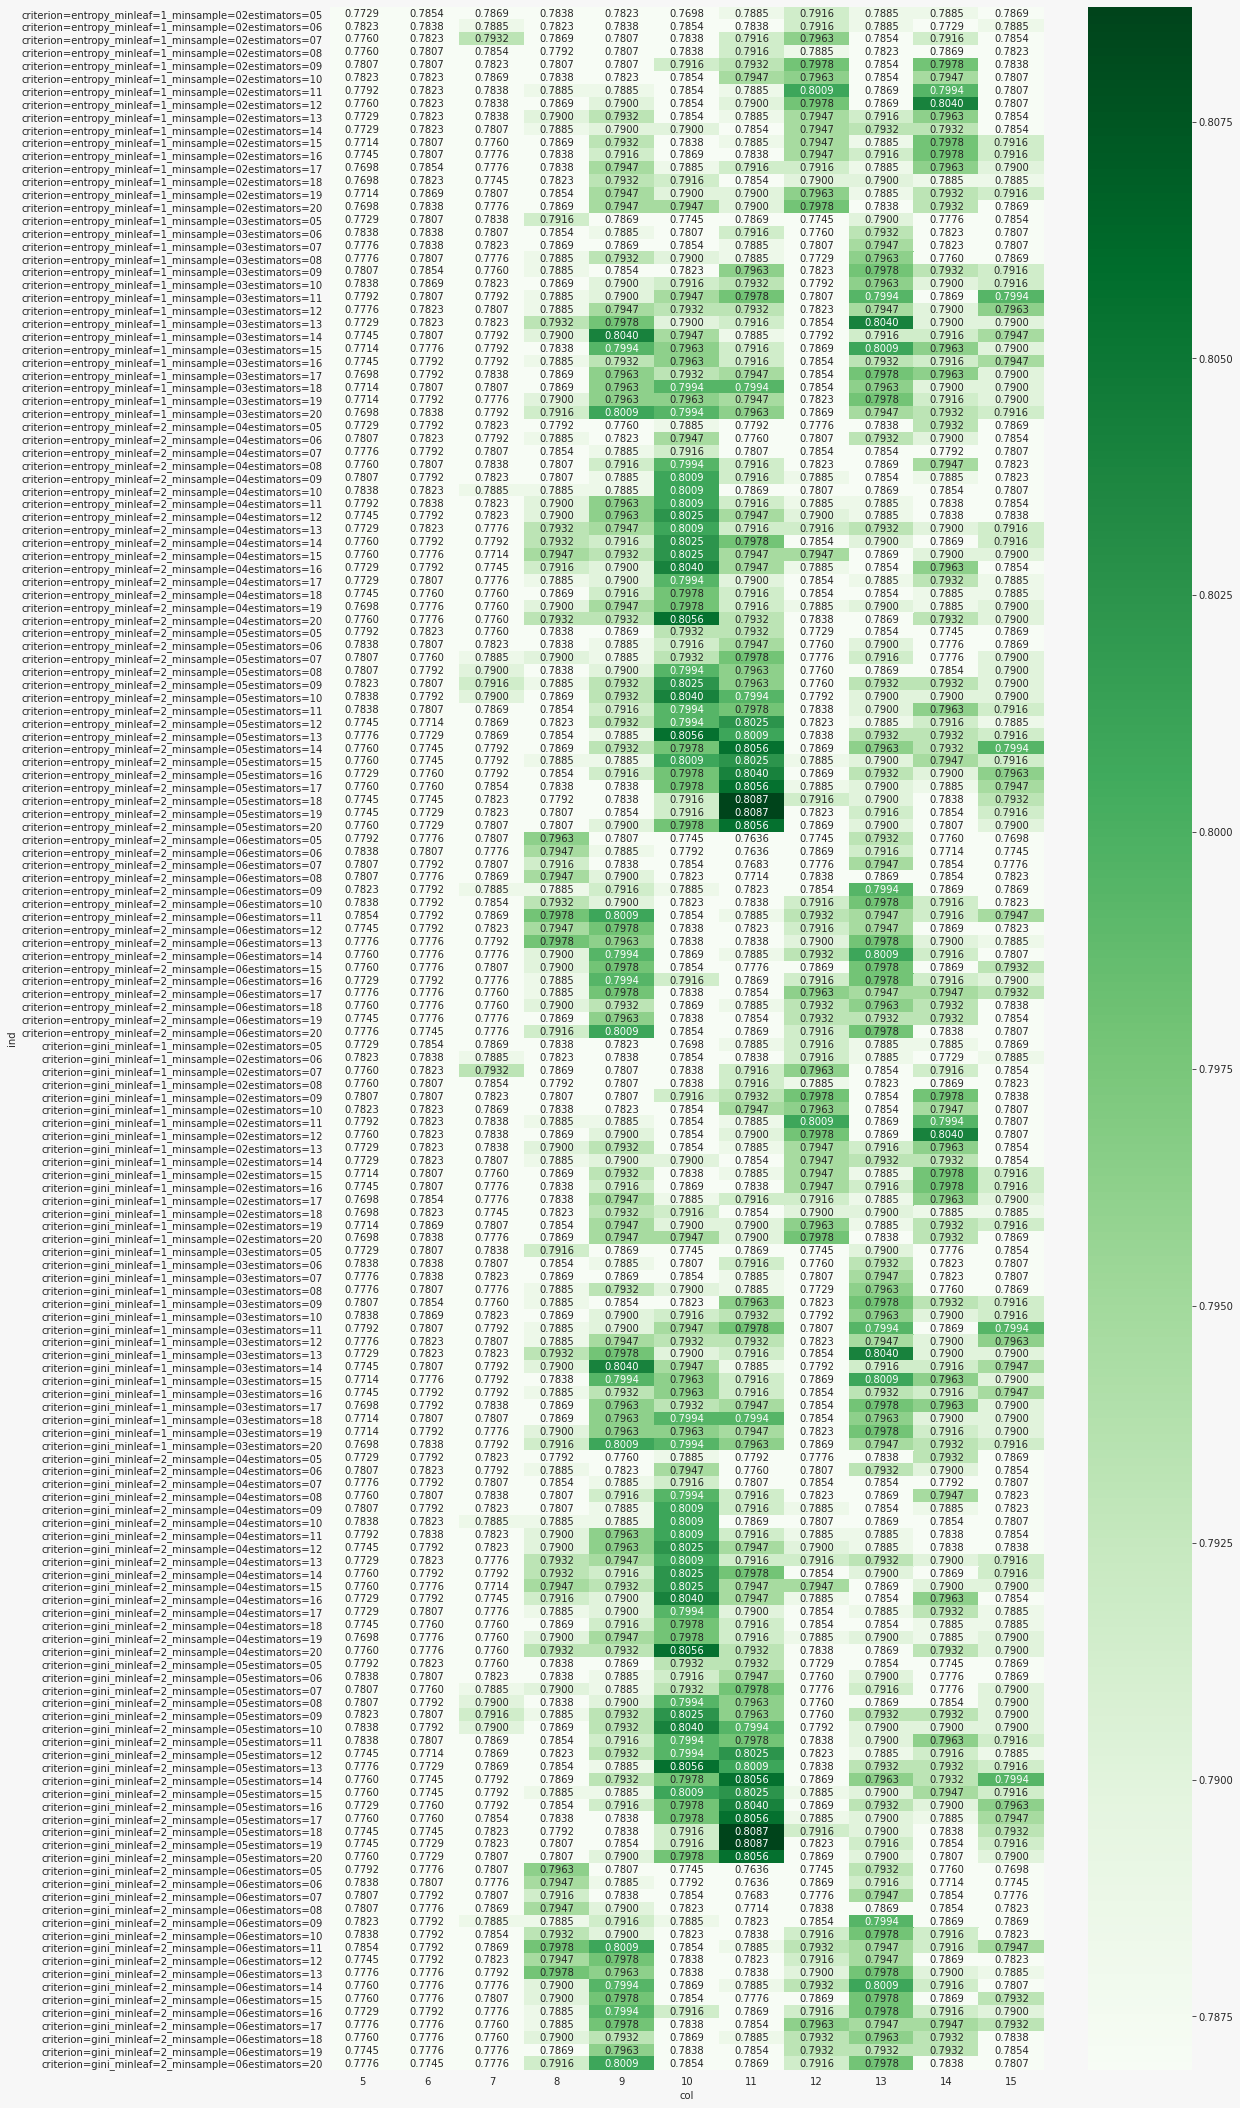

CPU times: user 1min 46s, sys: 3.57 s, total: 1min 49s
Wall time: 1min 50s


In [13]:
%%time

best_forest_model = None
best_result = 0

criterion_lst = ["gini", "entropy"]
arr_iter = []
for criterion in criterion_lst:
    for mslf in range(1,3):
        for mssp in range(mslf*2,mslf*3+1,1):
            for est in range(5, 21, 1):
                for depth in range (5, 16):
                    model = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth=depth
                                                   , min_samples_split=mssp, min_samples_leaf=mslf
                                                  )
                    model.fit(features_train, target_train) # обучим модель
                    predictions = model.predict(features_valid) # получим предсказания модели
                    result = accuracy_score(target_valid, predictions) # посчитаем качество модели
                    param_str = "RandomForestClassifier: n_estimators ="+str(est)+", max_depth="+str(depth)+ ', criterion='+criterion+"_minsample="+str(mssp)+"_minleaf="+str(mslf)
                    arr_iter.append([
                        'criterion='+criterion  +"_minleaf="+str(mslf)+"_minsample="+str(mssp).zfill(2)+'estimators='+str(est).zfill(2)
                        , depth
                        , result
                    ])
                    if result > best_result:
                        best_forest_model = model
                        best_result = result
                        best_param = param_str
                   
print("Acuracy наилучшей модели RandomForestClassifier на валидационной выборке:", best_result, "\nпараметры:", best_param)

show_heatmap_accuracy(arr_iter, 0.5)

### Вывод
Перебрав множество гиперпараметров у моделей и проверив на валидационной выборке получили следующие наилучшие модели

* Acuracy наилучшей модели DecisionTreeClassifier на валидационной выборке: 0.7931570762052877 <br>параметры: depth=8, criterion=entropy, minsample=10, minleaf=5

* Acuracy наилучшей модели LogisticRegression на валидационной выборке: 0.7293934681181959<br>параметры: solver=newton-cg, max_iter=30, c=1

* Acuracy наилучшей модели **RandomForestClassifier** на валидационной выборке: 0.8087091757387247<br>параметры: n_estimators =18, max_depth=11, criterion=gini, minsample=5, minleaf=2

Наилучшей моделью на валидационной выборке показывает себя RandomForestClassifier

Модели DecisionTreeClassifier и RandomForestClassifier склонны к переобучению и выбор оптимальных гиперпараметров чрезвычайно важен. Модель LogisticRegression не склонна к переобучению.

## Проверьте модель на тестовой выборке

Посчитаем не только accuracy, но и другие метрики

Диаграмма ошибок

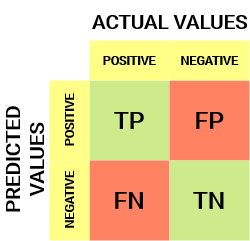


<b>Метрики</b>

$$Accuracy = \frac{TP+TN}{ALL}$$

$$Precision = \frac{TP}{TP+FP}$$

$$Recall = \frac{TP}{TP+FN}$$

$$Balanced\ accuracy = \frac{1}{2} * \left( \frac{TP}{TP+FN} + \frac{TN}{TN+FP} \right)$$

$$F1\ metric = 2 * \frac{Precision * Recall}{Precision + Recall}$$


In [14]:
## Функция для вывода всех метрик для набора моделей
def table_model_metrics(model_dic, features_test, target_test):
    res=[]
    for name, model in model_dic.items():
        if name in ['DUMMY', 'RANDOM']:
            predictions = model
        else:
            predictions = model.predict(features_test)
        accuracy = accuracy_score(target_test, predictions)
        precision = precision_score(target_test, predictions, zero_division=0)
        recall = recall_score(target_test, predictions)
        balanced_accuracy = balanced_accuracy_score(target_test, predictions)
        f_metric = f1_score(target_test, predictions, zero_division=0)
        
        res.append([name, accuracy, precision, recall, balanced_accuracy, f_metric])
        
    df = pd.DataFrame(res, columns=['name', 'accuracy', 'precision', 'recall', 'balanced_accuracy', 'f_metric'])
    return df

Делаем словарь моделей и запускаем функцию оценивания моделей разными метриками

Оценим на валидацонной выборке тоже, чтобы сравнить как изменилась точность на тестовой по сравнению с валидационной

Подкрасим результаты моделей, наилучшие по каждому критерию

In [15]:
model_d = {'DecisionTreeClassifier': best_tree_model,
           'LogisticRegression': best_logreg_model,
           'RandomForestClassifier': best_forest_model,
}

display(table_model_metrics(model_d, features_valid, target_valid).set_index('name').style.highlight_max(color='lightgreen').set_caption('VALID sample')
)

table_model_metrics(model_d, features_test, target_test).set_index('name').style.highlight_max(color='lightgreen').set_caption('TEST sample')



,accuracy,precision,recall,balanced_accuracy,f_metric
name,,,,,
DecisionTreeClassifier,0.793157,0.741007,0.515000,0.716868,0.607670
LogisticRegression,0.729393,0.842105,0.160000,0.573228,0.268908
RandomForestClassifier,0.808709,0.798450,0.515000,0.728155,0.626140


,accuracy,precision,recall,balanced_accuracy,f_metric
name,,,,,
DecisionTreeClassifier,0.783826,0.728000,0.464286,0.694112,0.566978
LogisticRegression,0.754277,0.913043,0.214286,0.602669,0.347107
RandomForestClassifier,0.791602,0.727941,0.505102,0.711164,0.596386


### Вывод

Для решения задачи наиболее подходящей является модель класса RandomForestClassifier. Результаты на тестовой выборке немного ниже чем на валидационной, что модет быть объяснено легкой переобученностью модели, но она все равно остается лучшей среди моделей других классов. Причем. лучшей не только по критерию accuracyЮ но и по recall, balanced_accuracy, f_metric

Модель LogisticRegression показала точность (accuracy) на тестовой выборке выше чем на валидационной. Что говорит о несклонности модели к переобучению

На тестовой выборке показатель точности каждой из моделей выше 0,75. Формально можно брать любую )))

## (бонус) Проверьте модели на адекватность

### Способ №1 Сравнение  по метрикам с DUMMY и RANDOM моделью

Считаем, что примитивная DUMMY модель всегда выдает медианный ответ, рассчитанный на тренировочной выборке

In [16]:
# DUMMY response
target_train.median()

0.0

Считаем, что примитивная RANDOM модель выдает случайный ответ ('1' с вероятностью p и '0' с вероятностью 1-p). Вероятность p рассчитана на тренировочной выборке

In [17]:
# RANDOM p
target_train.mean()

0.30549792531120334

Посчитаем метрики качества для всех трех моделей + для DUMMY и RANDOM

In [18]:
model_d = {'DecisionTreeClassifier': best_tree_model,
           'LogisticRegression': best_logreg_model,
           'RandomForestClassifier': best_forest_model,
           'DUMMY':[target_train.median()]*len(target_test),
           'RANDOM':np.random.binomial(1, target_train.mean(), size=len(target_test))
}
np.random.seed(12345)
table_model_metrics(model_d, features_test, target_test).set_index('name').style.highlight_max(color='lightgreen')


,accuracy,precision,recall,balanced_accuracy,f_metric
name,,,,,
DecisionTreeClassifier,0.783826,0.728000,0.464286,0.694112,0.566978
LogisticRegression,0.754277,0.913043,0.214286,0.602669,0.347107
RandomForestClassifier,0.791602,0.727941,0.505102,0.711164,0.596386
DUMMY,0.695179,0.000000,0.000000,0.500000,0.000000
RANDOM,0.573872,0.306931,0.316327,0.501564,0.311558


У нас мало признаков и основных признака всего два. Есть возможность построить scatterplot и посмотреть как модели  классифицировали объекты

Посмотрим


DecisionTreeClassifier


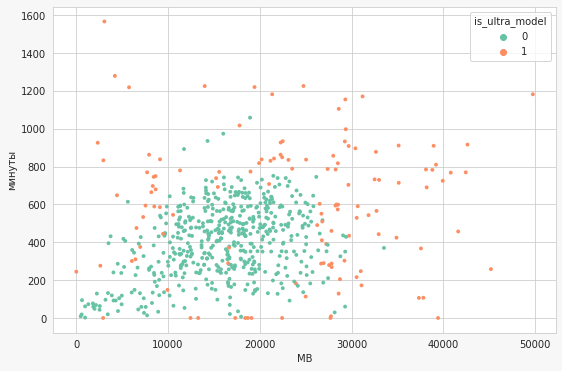


LogisticRegression


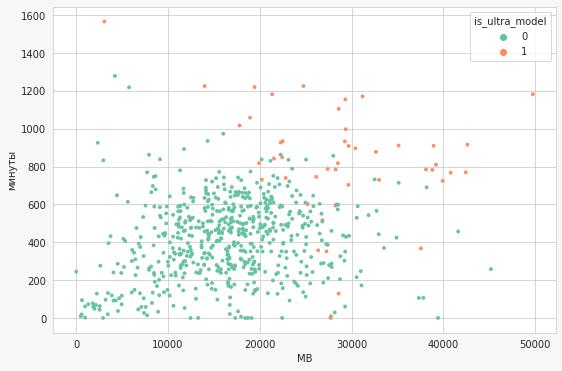


RandomForestClassifier


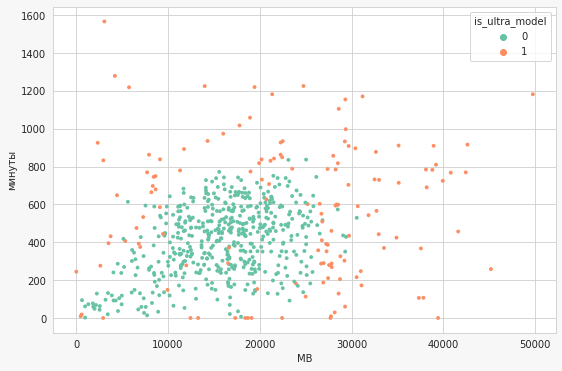


DUMMY


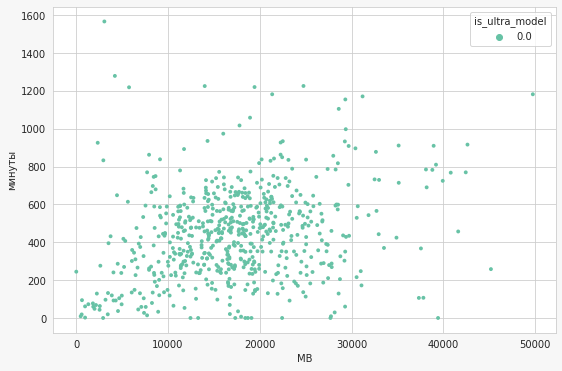


RANDOM


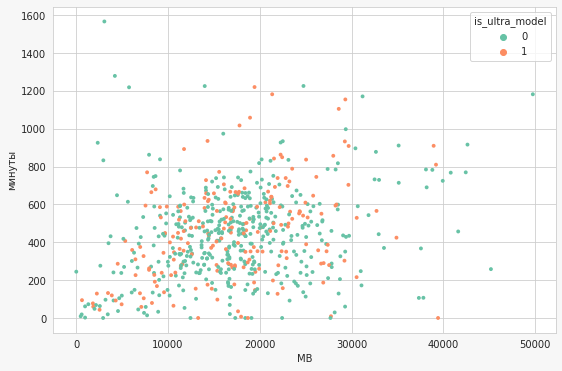

In [19]:
for name, model in model_d.items():
    if name in ['DUMMY', 'RANDOM']:
        predictions = model
    else:
        predictions = model.predict(features_test)
    t1 = features_test.copy()
    t1['is_ultra_model'] = predictions
    print("\n"+name)
    g= sns.scatterplot( x='mb_used', y='minutes', data=t1, hue='is_ultra_model'
                    , alpha=0.99
                    , edgecolor = 'none'
                    , s=15
    );
    g.set_xlabel('MB')
    g.set_ylabel('минуты')
    plt.show()

Видно, что 
* LogisticRegression присвоила ultra=1 для самых крупных значений признаков
* RandomForestClassifier и DecisionTreeClassifier определили облако центральное плотное как ultra =0, а края облака как ultra=1. Это рационально, и интуитивно понятно, учитывая знакомство с данными
* DUMMY всем присвоила 0
* RANDOM случайным образом

### Способ №2 Оценка на очевидных объектах

Второй способ проверить модель - посмотреть как она работает на очевидных случаях

При знакомстве с данными мы видели, что для ultra характерны большие разбросы от среднего. Например очень много гигабайт и минут, либо мало минут, но много гигабайт

Число минут среднее около 400, смс около 25, мегабайт около 16 000
большое число минут около 1000, смс более 200, мегабайт более 50 000

Делаем датасеты и ожидаемые результаты

0. пустые траты. Вероятно это не тариф ultra. Хотя по датасету такие значения были и для 1 и для 0 ultra
1. средние траты. Это не тариф ultra должен быть
2. Среднее число минут и нулевые смс и МБ. Это сильное отклонение от среднего, вероятно должно быть ultra
3. Большое число минут и нулевые смс и МБ. Это сильное отклонение от среднего, вероятно должно быть ultra
4. Много всего: и смс и минут и МБ. Должно быть ultra
5. Много МБ и нулевые минуты и смс. Это сильное отклонение от среднего, вероятно должно быть ultra
6. Много смс и нулевые минуты и МБ. Это сильное отклонение от среднего, вероятно должно быть ultra


In [20]:
features_a = pd.DataFrame([[0,0,0]
                           ,[400,25,16000]
                           ,[400,0,0]
                           ,[1000,0,0]
                           ,[1000,1000,50000]
                           ,[0,0,50000]
                           ,[0,200,0]]
                          , columns=['minutes','messages','mb_used'])
expected_a = [0, 0, 1, 1, 1, 1,1]


Лучшей моделью оказалась best_tree_model. Посомтрим как она себя покажет на данной искусственной выборке

In [21]:
np.random.seed(123)
model_d = {'DecisionTreeClassifier': best_tree_model,
           'LogisticRegression': best_logreg_model,
           'RandomForestClassifier': best_forest_model,
           'DUMMY':[target_train.median()]*len(features_a),
           'RANDOM':np.random.binomial(1, target_train.mean(), size=len(features_a))
}
for name, model in model_d.items():
    if name in ['DUMMY', 'RANDOM']:
        predictions = model
    else:
        predictions = model.predict(features_a)
    t=features_a.copy()
    t['expected'] = expected_a
    t['prediction'] = predictions
    t['correct'] = t['prediction']==t['expected']
    fmt_dict = {'minutes':'{:,.3f}', 'messages':'{:}', 'mb_used':'{:,.3f}'}
    display(t.style.highlight_min('correct', 'red').highlight_max('correct', 'lightgreen').format(fmt_dict).set_caption(name))


,minutes,messages,mb_used,expected,prediction,correct
0,0.000,0,0.000,0,1,False
1,400.000,25,"16,000.000",0,0,True
2,400.000,0,0.000,1,1,True
3,"1,000.000",0,0.000,1,1,True
4,"1,000.000",1000,"50,000.000",1,1,True
5,0.000,0,"50,000.000",1,1,True
6,0.000,200,0.000,1,1,True


,minutes,messages,mb_used,expected,prediction,correct
0,0.000,0,0.000,0,0,True
1,400.000,25,"16,000.000",0,0,True
2,400.000,0,0.000,1,0,False
3,"1,000.000",0,0.000,1,0,False
4,"1,000.000",1000,"50,000.000",1,1,True
5,0.000,0,"50,000.000",1,0,False
6,0.000,200,0.000,1,0,False


,minutes,messages,mb_used,expected,prediction,correct
0,0.000,0,0.000,0,1,False
1,400.000,25,"16,000.000",0,0,True
2,400.000,0,0.000,1,1,True
3,"1,000.000",0,0.000,1,1,True
4,"1,000.000",1000,"50,000.000",1,1,True
5,0.000,0,"50,000.000",1,1,True
6,0.000,200,0.000,1,1,True


,minutes,messages,mb_used,expected,prediction,correct
0,0.000,0,0.000,0,0.000000,True
1,400.000,25,"16,000.000",0,0.000000,True
2,400.000,0,0.000,1,0.000000,False
3,"1,000.000",0,0.000,1,0.000000,False
4,"1,000.000",1000,"50,000.000",1,0.000000,False
5,0.000,0,"50,000.000",1,0.000000,False
6,0.000,200,0.000,1,0.000000,False


,minutes,messages,mb_used,expected,prediction,correct
0,0.000,0,0.000,0,1,False
1,400.000,25,"16,000.000",0,0,True
2,400.000,0,0.000,1,0,False
3,"1,000.000",0,0.000,1,0,False
4,"1,000.000",1000,"50,000.000",1,1,True
5,0.000,0,"50,000.000",1,0,False
6,0.000,200,0.000,1,1,True


### Вывод
Видим, что модели DecisionTreeClassifier и RandomForestClassifier в целом хорошо справилась, явных глюков нет. Ошибка только одна: выбрать тариф для нулевых трат (МБ, минут и смс). Тут сам ответ не особо очевиден и то, что модель не справилась не так уж страшно

LogisticRegression справилась хуже. Да и по метрикам на тестовой выборке она тоже хуже. 2 ошибки

Модели DUMMY и RANDOM: очень плохо. 5 ошибок у DUMMY и 4 ошибки у RANDOM. Это не удивительно )))

## Итоговый вывод

1. Изучив данные, выяснили, что 
 * даные без пропусков, чистые, без явных выбросов, число объектов 3214
 * число объектов с признаком is_ultra =1 составляют 30.6% от выборки
 * calls и minutes имеют высокую корреляцию, поэтому calls убрали из числа рассматриваемых признаков
2. Разница между ultra и not_ultra в разбросе точек, причем у ultra во все стороны. Облака точек пересекаются и центры близки, значит почти любая модель будет регулярно совершать ошибки около центра облака ultra=0.
3. Выборка разбита на 3 части: обучающая, валидационная и тестовая в соотношении 3:1:1
4. Исследованы три модели классификации: DecisionTreeClassifier, LogisticRegression и RandomForestClassifier и найдены оптимальные гиперпараметры моделей. Модели DecisionTreeClassifier и RandomForestClassifier склонны к переобучению и выбор оптимальных гиперпараметров чрезвычайно важен. Модель LogisticRegression не склонна к переобучению.
5. Лучшей оказалась  модель RandomForestClassifier с параметрами : n_estimators =18, max_depth=11, criterion=gini, minsample=5, minleaf=2. На тестовой выборке она показала результат accuracy 0,792. Модели конкуренты отстали не кардинально. Так, DecisionTreeClassifier на валидационной выборке отстала на 1 п.п., а LogisticRegression на 7 п.п.
5. Оценена адекватность всех моделей, которая показала хорошие результаты моделей по сравнению со случайными моделями DUMMY и RANDOM

## Рекомендации

* Выбранная модель может быть еще раз обучена на бОльшей выборке. Это позволит еще немного увеличить точность
* Проверить входные данные. Целевой признак составлен неоптимально. Возможно стоит его пересмотреть и пересчитать

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
